---
# Simulate ISIs for experiment

The goal of this notebook is to find a strategy in which we find an optimal set of inter-stimulus intervals for the Hole-Response experiment. Here, we've simulated the response of a target pRF to full-field stimulus minus a mask to maximize suppression, as well as to growing stimuli to find a stimulus that maximizes a positive response. Here, we'll use the stimulus sizes for both to recreate a design matrix which we'll feed into the pRF estimates of the target

In [1]:
from linescanning import (
    prf,
    utils,
    plotting,
    glm,
    simulate
)

from alive_progress import alive_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
import os
import seaborn as sns
opj = os.path.join

In [2]:
subject = "sub-005"
hemi = "L"
proj_dir = os.environ.get("DIR_DATA_HOME")
prf_file = opj(
    proj_dir, 
    "derivatives", 
    "pycortex", 
    subject, 
    f"{subject}_model-norm_desc-best_vertices.csv")

pars = pd.read_csv(prf_file).set_index(["hemi"])
pars

,x,y,prf_size,prf_ampl,bold_bsl,surr_ampl,surr_size,neur_bsl,surr_bsl,A,...,r2,size ratio,suppression index,ecc,polar,index,position,normal,stim_sizes,stim_betas
hemi,,,,,,,,,,,,,,,,,,,,,
L,2.544878,-0.427466,0.869046,3.755531,0.0,0.459976,3.556716,47.984649,100.137513,3.755531,...,0.444077,4.092669,2.051527,2.58053,-0.166418,3528,[-22.362085 -85.82565 -18.253815],[-0.41409222 -0.8828969 0.22140619],[2.89567456 5.41365244],[-0.40160517 1.68891931]
R,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,NaN,0.00000,0.000000,313527,[ -1.1303978 -82.96577 6.3015747],[ 0.00530441 0.9995553 -0.02934384],[2.51797788 7.42803474],[-0.06507191 2.0140195 ]


---
# Simulate with GLM

In [3]:
# fetch stimulus betas
stim_betas = utils.string2float(pars["stim_betas"][hemi])
stim_betas

array([-0.40160517,  1.68891931])

In [4]:
# settings
settings_path = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/LineExps/ActNorm/settings.yml"
with open(settings_path, 'r', encoding='utf8') as f_in:
    settings = yaml.safe_load(f_in)

TR = 0.105
osf = 1000
n_trials = settings['design'].get('n_trials')
stim_duration = settings['design'].get('stim_duration')
start_duration = settings['design'].get('start_duration')
end_duration = settings['design'].get('end_duration')
theor_total_duration = 336 #s -> 6 minutes 
hrf_diff = 0.08

# define HRF
dt = 1/osf
time_points = np.linspace(0, 25, np.rint(float(25)/dt).astype(int))
hrf_0 = glm.double_gamma(time_points, lag=5)
hrf_100ms = glm.double_gamma(time_points, lag=(5-hrf_diff))

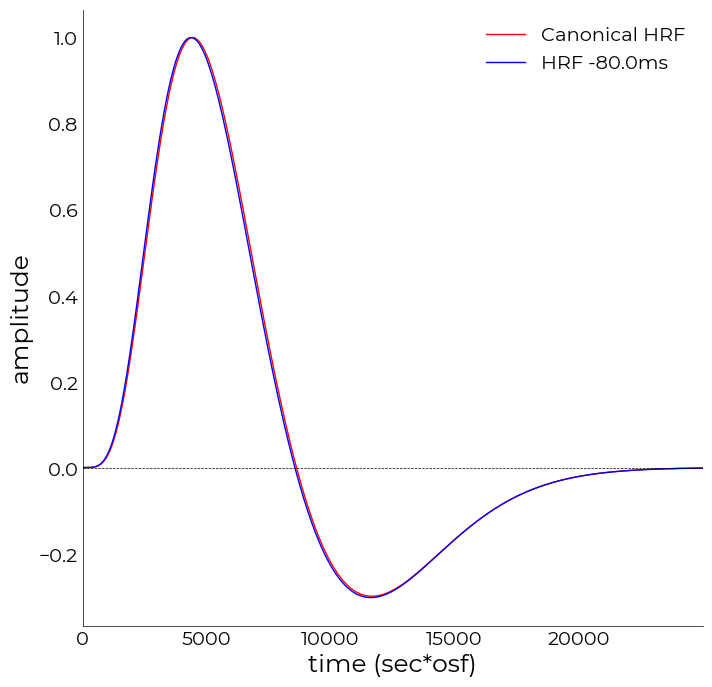

In [5]:
%matplotlib inline
plotting.LazyPlot(
    [hrf_0,hrf_100ms],
    figsize=(8,8),
    x_label="time (sec*osf)",
    y_label="amplitude",
    labels=["Canonical HRF",f"HRF -{hrf_diff*1000}ms"],
    color=["r","b"],
    line_width=1,
    add_hline=0)

ITIs created with total ITI duration of 223.35s after 9 iterations
Total experiment time: 335.35s (= 3194 samples)


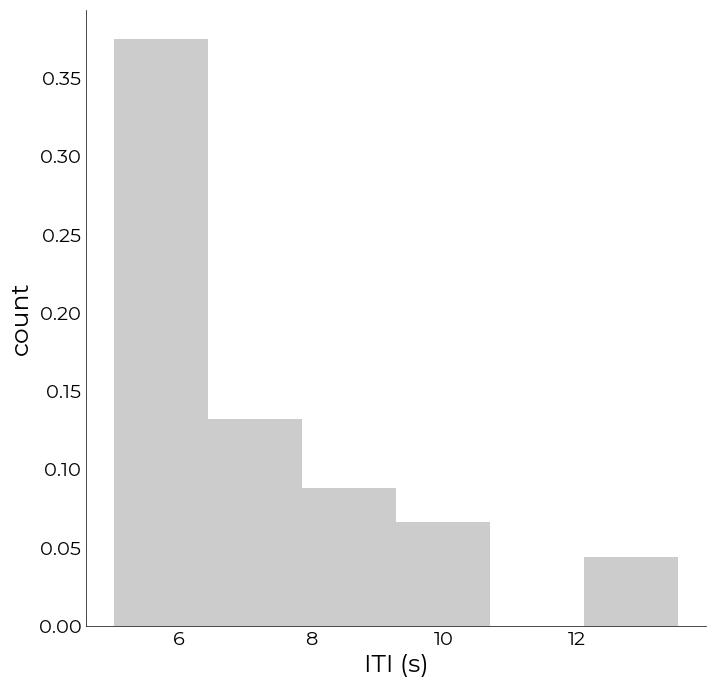

In [7]:
n_iters = 1
events = ["act","norm"]
stim_ratio = [0.25,0.75]
n_events = len(events)
presented_stims = np.hstack([np.full(int(n_trials*stim_ratio[ii]), ii, dtype=int) for ii in range(n_events)])
presented_stims

# np.random.seed(1123)
np.random.shuffle(presented_stims)

iti_obj = simulate.ITI(
    tmin=settings['design'].get('minimal_iti_duration'),
    tmax=settings['design'].get('maximal_iti_duration'),
    tmean=settings['design'].get('mean_iti_duration'),
    n_trials=n_trials,
    leeway=settings['design'].get('total_iti_duration_leeway'),
    stim_duration=stim_duration,
    total_duration=theor_total_duration,
    start_duration=start_duration,
    end_duration=end_duration,
    verbose=True,
    events=events,
    seq=presented_stims
)

iti_obj.plot_iti_distribution()

In [17]:
np.savetxt("/data1/projects/MicroFunc/Jurjen/programs/project_repos/LineExps/ActNorm/order_1.txt", presented_stims.astype(int))
for ii in range(2):
    presented_stims2 = presented_stims.copy()
    np.random.shuffle(presented_stims2)
    np.savetxt(f"/data1/projects/MicroFunc/Jurjen/programs/project_repos/LineExps/ActNorm/order_{ii+2}.txt", presented_stims2.astype(int))

In [6]:
n_iters = 1000
events = ["act","norm"]
stim_ratio = [0.25,0.75]
n_events = len(events)
presented_stims = np.hstack([np.full(int(n_trials*stim_ratio[ii]), ii, dtype=int) for ii in range(n_events)])
presented_stims

np.random.seed(1123)
np.random.shuffle(presented_stims)

# LUT variance
# 0 = var_act
# 1 = var_suppr
# 2 = var_diff for activation predictor
# 3 = var_diff for suppression predictor

pkl_file = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/simulate_ratio.pkl"
if not os.path.exists(pkl_file):
    df_isis = []
    df_var = []

    with alive_bar(n_iters) as bar:
    
        for it in range(n_iters):

            bar()
            df_variance = {}
            for el in ["variance","code", "name"]:
                df_variance[el] = []

            iti_obj = simulate.ITI(
                tmin=settings['design'].get('minimal_iti_duration'),
                tmax=settings['design'].get('maximal_iti_duration'),
                tmean=settings['design'].get('mean_iti_duration'),
                n_trials=n_trials,
                leeway=settings['design'].get('total_iti_duration_leeway'),
                stim_duration=stim_duration,
                total_duration=theor_total_duration,
                start_duration=start_duration,
                end_duration=end_duration,
                verbose=False,
                events=events,
                seq=presented_stims
            )

            func_vols = round(iti_obj.total_experiment_time/TR)

            # make stimulus vector
            stims = glm.make_stimulus_vector(
                iti_obj.get_onsets(), 
                scan_length=func_vols, 
                osf=osf, 
                type='block', 
                block_length=stim_duration)

            # convolve with HRF
            stim_vector = glm.convolve_hrf([hrf_0,hrf_100ms], stims)

            # resample to functional time domain
            stim_vector_resampled = glm.resample_stim_vector(stim_vector, func_vols)

            # get predictions by multiplying response magnitude to optimal stimulus (beta) with convolved stimulus vector
            pred_act    = [stim_vector_resampled["act"][:,ii]*stim_betas[1] for ii in range(len([hrf_0,hrf_100ms]))]
            pred_suppr  = [stim_vector_resampled["norm"][:,ii]*stim_betas[0] for ii in range(len([hrf_0,hrf_100ms]))]

            # get variances
            var_act         = np.var(pred_act[0])
            var_suppr       = np.var(pred_suppr[0])
            var_act_diff    = np.var(np.abs(pred_act[1]-pred_act[0]))
            var_suppr_diff  = np.var(np.abs(pred_suppr[1]-pred_suppr[0]))

            # append
            for ix,(var,nn) in enumerate(zip(
                [var_act,var_suppr,var_act_diff,var_suppr_diff],
                ["act","suppr","act_diff","suppr_diff"]
                )):

                for var,el in zip(
                    ["variance","code","name"],
                    [var,ix,nn]):

                    df_variance[var].append(el)
                
            df_variance = pd.DataFrame(df_variance)
            df_variance["it"] = it
            df_variance["isi_obj"] = iti_obj
            df_var.append(df_variance)

            # # keep track of ISIs
            # df_isi = pd.DataFrame(iti_obj.itis, columns=[f"iter-{it}"])
            # df_isis.append(df_isi)

    df_var = pd.concat(df_var)
    df_var.to_pickle(pkl_file)
    # df_isis = pd.concat(df_isis, axis=1)
    # df_isis["events"] = np.array([events[i] for i in presented_stims])
else:
    print(f"Reading '{pkl_file}'")
    df_var = pd.read_pickle(pkl_file)

Reading '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/simulate_ratio.pkl'


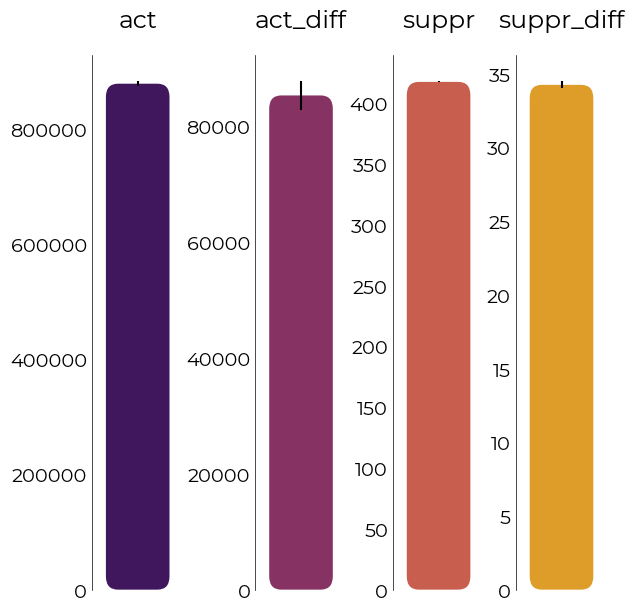

In [7]:
cols = sns.color_palette("inferno", 4)
fig,axs = plt.subplots(ncols=4, figsize=(6,6), constrained_layout=True)

for ix,el in enumerate(list(np.unique(df_var["name"].values))):
    ax = axs[ix]
    plotting.LazyBar(
        utils.select_from_df(df_var, expression=f"code = {ix}"),
        x="code",
        y="variance",
        axs=ax,
        title2=el,
        sns_ori="v",
        fancy=True,
        color=cols[ix],
        sns_offset=4,
        fancy_denom=6,
        error="std"
    )

In [18]:
# get suppression variances
df_suppr = utils.select_from_df(df_var, expression="code = 1")

# find two indices closest to max variance
ix,var = utils.find_nearest(df_suppr.variance.values, df_suppr.variance.max(), return_nr=3)

# find isi-sets
for x,i in enumerate(ix):
    print(f"ISI set #{x+1} from iteration {i}")
    iti_obj = df_suppr.isi_obj.iloc[i]
    iti_obj.to_file(opj(os.path.dirname(settings_path), f"itis_{x+1}.txt"))

ISI set #1 from iteration 890
ISI set #2 from iteration 858
ISI set #3 from iteration 159


Iteration 399 maximizes 'act'
Iteration 890 maximizes 'act_diff'
Iteration 45 maximizes 'suppr'
Iteration 144 maximizes 'suppr_diff'


Text(0.5, 1.1, 'ISI distribution & stimilus vector when maximizing variance of each element')

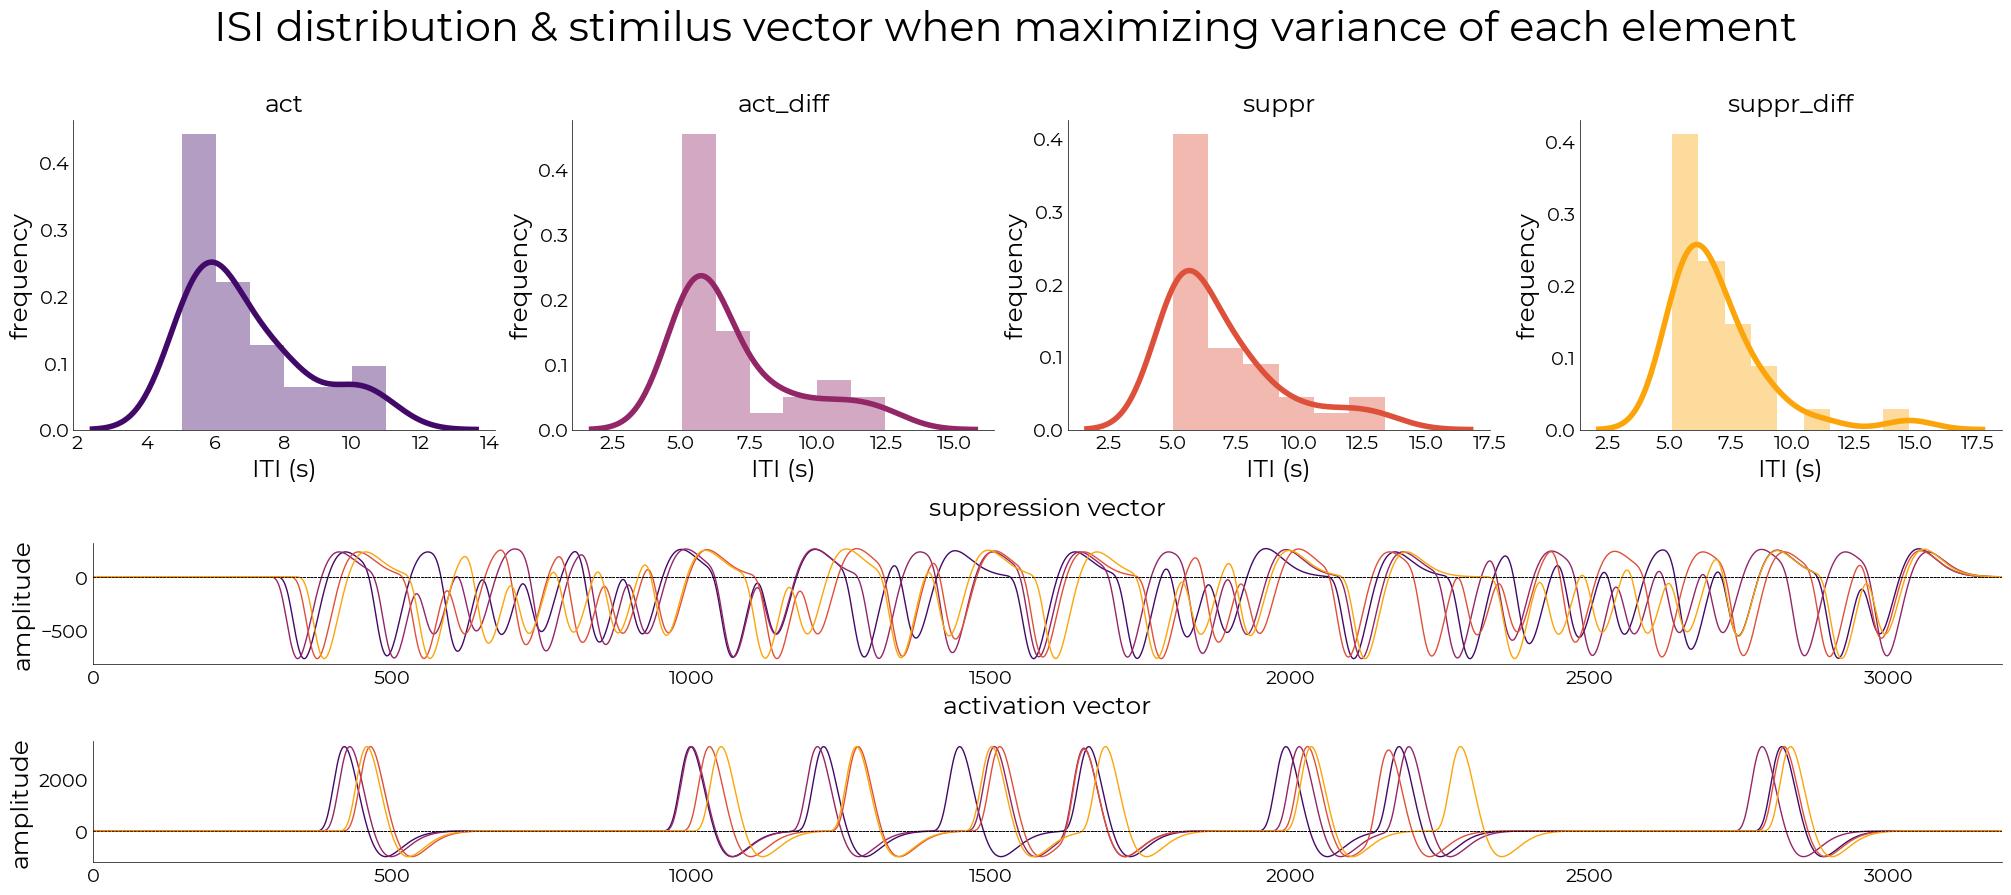

In [9]:
fig = plt.figure(figsize=(20,8), constrained_layout=True)
sf = fig.subfigures(nrows=2)
sf1 = sf[0].subplots(ncols=4)
sf2 = sf[1].subplots(nrows=2)

for ix,el in enumerate(list(np.unique(df_var["name"].values))):

    # get max variance for all elements
    max_var = utils.select_from_df(df_var, expression=f"code = {ix}")
    max_var_ix = max_var.loc[max_var["variance"].idxmax()].it
    print(f"Iteration {max_var_ix} maximizes '{el}'")

    # get corresponding set of ITIs
    max_var_isi_obj = utils.select_from_df(df_var, expression=f"it = {max_var_ix}")["isi_obj"].iloc[0]
    max_var_isis = max_var_isi_obj.itis

    # plot distribution
    ax = sf1[ix]
    plotting.LazyHist(
        max_var_isis,
        axs=ax,
        kde=True,
        hist=True,
        fill=False,
        title=el,
        y_label2="frequency",
        x_label2="ITI (s)",
        color=cols[ix],
        hist_kwargs={"alpha": 0.4},
        kde_kwargs={"linewidth": 4}
    )

    func_vols = round(max_var_isi_obj.total_experiment_time/TR)

    # make stimulus vector
    stims = glm.make_stimulus_vector(
        max_var_isi_obj.get_onsets(), 
        scan_length=func_vols, 
        osf=osf, 
        type='block',
        block_length=stim_duration)

    # convolve with HRF
    stim_vector = glm.convolve_hrf([hrf_0], stims)

    # resample to functional time domain
    stim_vector_resampled = glm.resample_stim_vector(stim_vector, func_vols)

    for qq,(tag,lbl) in enumerate(zip(["norm","act"],["suppression","activation"])):
        input_data = stim_vector_resampled[tag][:,0]*stim_betas[qq]
        if ix == 0:
            set_title = f"{lbl} vector"
            y_label = "amplitude"
        else:
            set_title = None
            y_label = None

        plotting.LazyPlot(
            input_data,
            axs=sf2[qq],
            line_width=1,
            add_hline=0,
            color=cols[ix],
            y_label=y_label,
            title=set_title)

fig.suptitle("ISI distribution & stimilus vector when maximizing variance of each element", fontsize=30, y=1.1)
# fname = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/simulate.pdf"
# fig.savefig(
#     fname,
#     bbox_inches="tight",
#     dpi=300,
#     facecolor="white"
# )

---
# Simulate as pRF experiment

In [7]:
SR_ = prf.SizeResponse(
    params=pars, 
    model="norm"
)

# size-response
fill_cent, fill_cent_sizes = SR_.make_stimuli(
    factor=1,
    dt="fill"
)

# hole-response
hole_cent, hole_cent_sizes = SR_.make_stimuli(
    factor=1,
    dt="hole"
)

In [8]:
# fetch stimulus sizes
stim_sizes = utils.string2float(pars["stim_sizes"][hemi])
stim_sizes

array([1.63668562, 5.66545023])

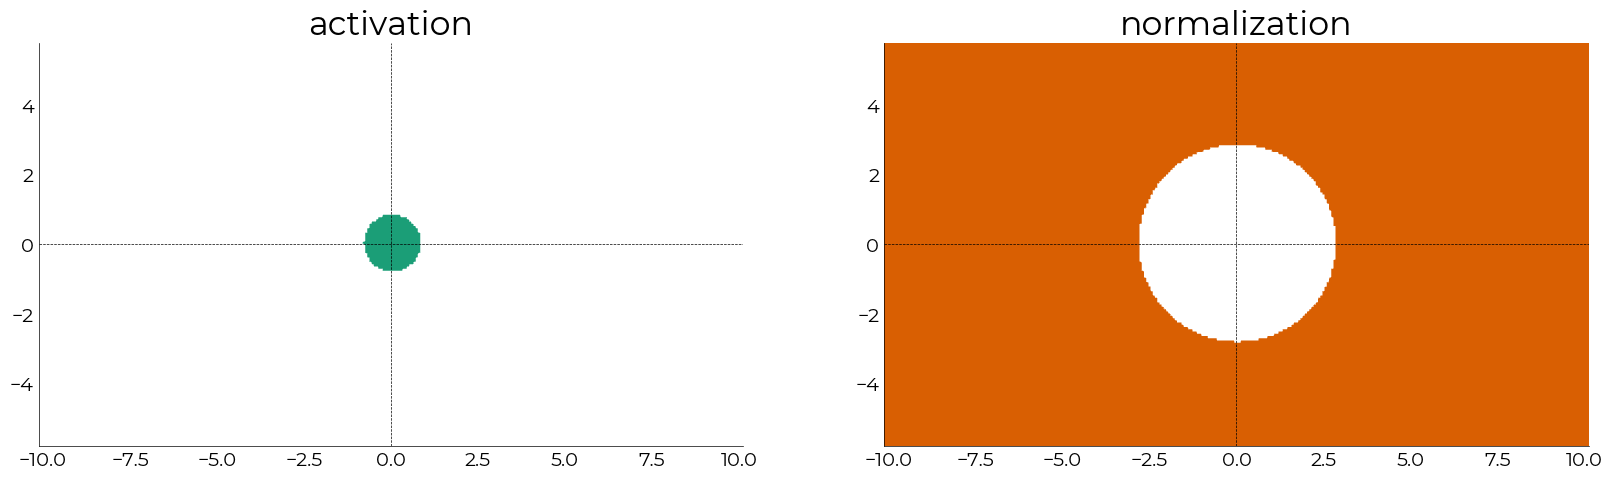

In [9]:
%matplotlib inline
# plot
cols = ["#1B9E77","#D95F02"]


fig,axs = plt.subplots(ncols=2, figsize=(20,6))
selected_stims = []
for x,(ss,stims,sizes,tag) in enumerate(zip(
    stim_sizes, 
    [fill_cent,hole_cent],
    [fill_cent_sizes,hole_cent_sizes],
    ["activation","normalization"])):
    
    # find corresponding stimulus given stimulus size
    ix = utils.find_nearest(sizes, ss)[0]
    img = stims[...,ix]

    SR_.plot_stim_size( 
        img, 
        ax=axs[x], 
        clip=False, 
        cmap=cols[x],
        vf_extent=SR_.vf_extent,
        axis=True)
    
    axs[x].set_title(tag, fontsize=24)
    plotting.conform_ax_to_obj(axs[x], font_size=24)
    selected_stims.append(img)

    # axs.axis('off')

In [15]:
n_iters = 200

# LUT variance
# 0 = var_act
# 1 = var_suppr
# 2 = var_diff for activation predictor
# 3 = var_diff for suppression predictor

pkl_file = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/simulate_prf.pkl"

# Selecting hemi-L parameters and set position to 0
insert_pars = utils.select_from_df(pars, expression="hemi = L")
for ii in ["x","y"]:
    insert_pars[ii] = 0

# Converting to array
l_pars = prf.Parameters(insert_pars, model="norm").to_array()

if not os.path.exists(pkl_file):
    df_isis = []
    df_var = []

    with alive_bar(n_iters) as bar:

        for it in range(n_iters):

            df_variance = {}
            for el in ["variance","code", "name"]:
                df_variance[el] = []

            iti_obj = simulate.ITI(
                tmin=settings['design'].get('minimal_iti_duration'),
                tmax=settings['design'].get('maximal_iti_duration'),
                tmean=settings['design'].get('mean_iti_duration'),
                n_trials=n_trials,
                leeway=settings['design'].get('total_iti_duration_leeway'),
                stim_duration=stim_duration,
                total_duration=theor_total_duration,
                start_duration=start_duration,
                end_duration=end_duration,
                verbose=False,
                events=events,
                seq=presented_stims
            )

            # make square because the pRF has square dimensions
            n_samples = round(iti_obj.total_experiment_time/TR)
            dm = iti_obj.create_prf_design(
                iti_obj,
                stims=selected_stims,
                events=events,
                make_square=True)

            # initialize object without actual data; mainly insert design matrix
            obj_ = prf.pRFmodelFitting(
                None,
                design_matrix=dm,
                TR=TR,
                verbose=False,
                hrf=[1,5,0]
            )

            # delayed HRF
            obj_delay = prf.pRFmodelFitting(
                None,
                design_matrix=dm,
                TR=TR,
                verbose=False,
                hrf=[1,5-hrf_diff,0]
            )        

            obj_.load_params(l_pars, model="norm", stage="iter")
            obj_delay.load_params(l_pars, model="norm", stage="iter")

            # get timecourse + make plot
            _,_,_,tc_def = obj_.plot_vox(
                vox_nr=0,
                title="pars", 
                model="norm",
                make_figure=False)

            _,_,_,tc_delayed = obj_delay.plot_vox(
                vox_nr=0,
                title="pars", 
                model="norm",
                make_figure=False)
            
            # isolate negative area
            tmp_delay = np.squeeze(tc_delayed)
            tc_neg = np.zeros_like(tmp_delay)
            tc_neg[tmp_delay<0] = tmp_delay[tmp_delay<0]
            var_iso = abs(np.var(tc_neg))

            # get variance
            var_def = np.var(tc_def)
            var_delay = np.var(tc_delayed)
            var_diff = np.var(tc_def-tc_delayed)

            # append
            for ix,(var,nn) in enumerate(zip(
                [var_def,var_delay,var_diff, var_iso],
                ["default","delayed","difference","isolated suppr"])):
        
                for var,el in zip(
                    ["variance","code","name"],
                    [var,ix,nn]):

                    df_variance[var].append(el)
                
            df_variance = pd.DataFrame(df_variance)
            df_variance["it"] = it
            df_variance["isi_obj"] = iti_obj
            df_var.append(df_variance)

            # progress bar
            bar()
            
    df_var = pd.concat(df_var)
    df_var.to_pickle(pkl_file)
else:
    print(f"Reading '{pkl_file}'")
    df_var = pd.read_pickle(pkl_file)

|████████████████████████████████████████| 200/200 [100%] in 3:15:42.2 (0.02/s) 


Text(0.5, 1.1, 'variance of different elements')

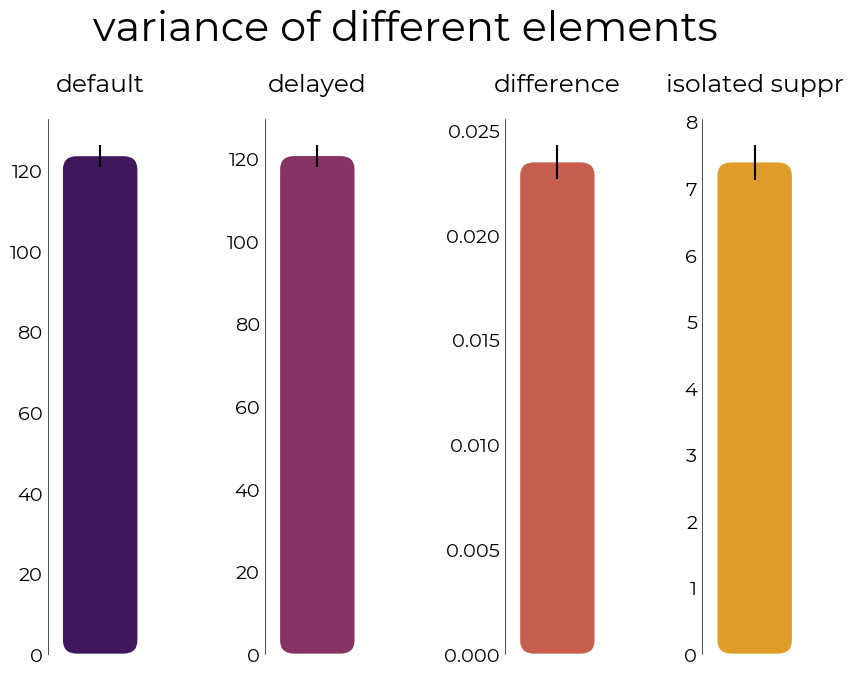

In [16]:
n_elements = list(np.unique(df_var["name"].values))
cols = sns.color_palette("inferno", len(n_elements))
fig,axs = plt.subplots(
    ncols=len(n_elements), 
    figsize=(8,6), 
    constrained_layout=True,
    gridspec_kw={"wspace": 0.4})

for ix,el in enumerate(n_elements):
    ax = axs[ix]
    plotting.LazyBar(
        utils.select_from_df(df_var, expression=f"code = {ix}"),
        x="code",
        y="variance",
        axs=ax,
        title2=el,
        sns_ori="v",
        fancy=True,
        color=cols[ix],
        sns_offset=4,
        fancy_denom=6,
        error="std"
    )

fig.suptitle("variance of different elements", fontsize=30, y=1.1)

Iteration 180 maximizes 'default'
Iteration 180 maximizes 'delayed'
Iteration 180 maximizes 'difference'
Iteration 25 maximizes 'isolated suppr'


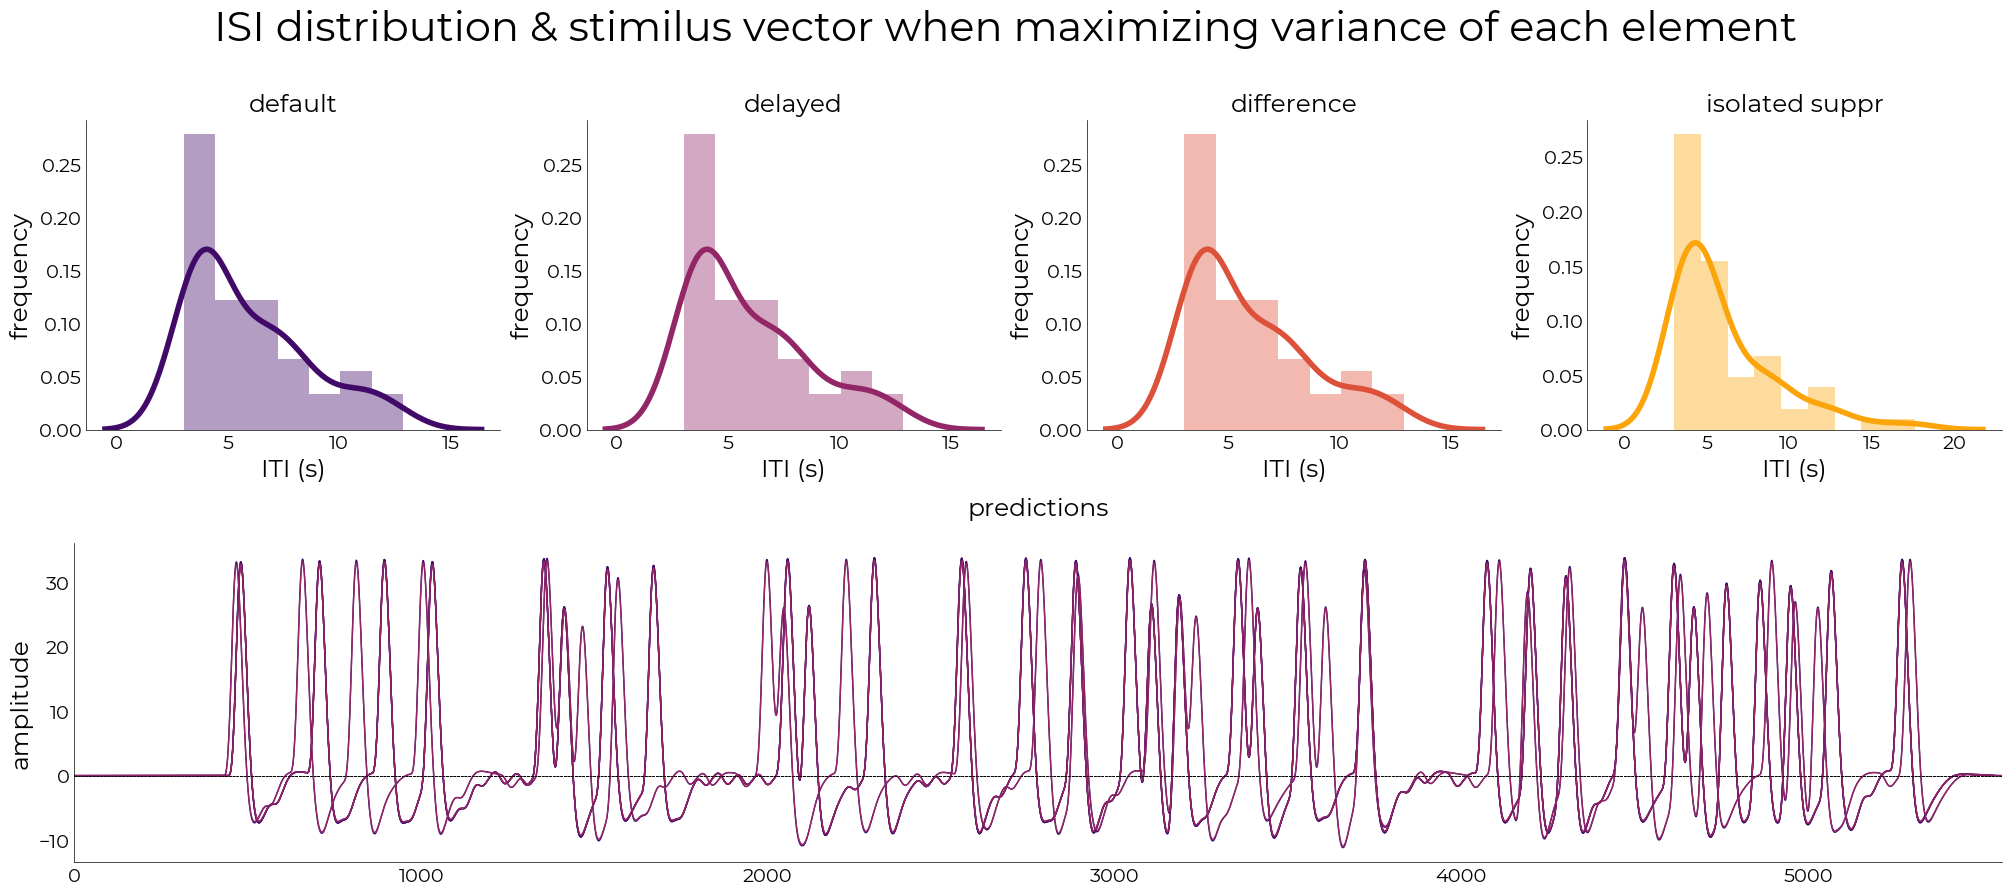

In [17]:
fig = plt.figure(figsize=(20,8), constrained_layout=True)
sf = fig.subfigures(nrows=2)
sf1 = sf[0].subplots(ncols=len(n_elements))
sf2 = sf[1].subplots()

for ix,el in enumerate(n_elements):

    # get max variance for all elements
    max_var = utils.select_from_df(df_var, expression=f"code = {ix}")
    max_var_ix = max_var.loc[max_var["variance"].idxmax()].it
    print(f"Iteration {max_var_ix} maximizes '{el}'")

    # get corresponding set of ITIs
    max_var_isi_obj = utils.select_from_df(df_var, expression=f"it = {max_var_ix}")["isi_obj"].iloc[0]
    max_var_isis = max_var_isi_obj.itis

    # plot distribution
    ax = sf1[ix]
    plotting.LazyHist(
        max_var_isis,
        axs=ax,
        kde=True,
        hist=True,
        fill=False,
        title=el,
        y_label2="frequency",
        x_label2="ITI (s)",
        color=cols[ix],
        hist_kwargs={"alpha": 0.4},
        kde_kwargs={"linewidth": 4}
    )

    dm = max_var_isi_obj.create_prf_design(
        max_var_isi_obj,
        stims=selected_stims,
        events=events,
        make_square=True)

    # initialize object without actual data; mainly insert design matrix
    obj_ = prf.pRFmodelFitting(
        None,
        design_matrix=dm,
        TR=TR,
        verbose=False,
        hrf=[1,5,0]
    )

    # delayed HRF
    obj_delay = prf.pRFmodelFitting(
        None,
        design_matrix=dm,
        TR=TR,
        verbose=False,
        hrf=[1,5-hrf_diff,0]
    )        

    obj_.load_params(l_pars, model="norm", stage="iter")
    obj_delay.load_params(l_pars, model="norm", stage="iter")

    # get timecourse + make plot
    _,_,_,tc_def = obj_.plot_vox(
        vox_nr=0,
        title="pars", 
        model="norm",
        make_figure=False)

    _,_,_,tc_delayed = obj_delay.plot_vox(
        vox_nr=0,
        title="pars", 
        model="norm",
        make_figure=False)

    if ix == 0:
        x_lbl = "volumes"
        y_lbl = "amplitude"
        title = "predictions"
    else:
        # set all to None
        x_lbl = y_lbl = title = None

    plotting.LazyPlot(
        [tc_def,tc_delayed],
        axs=sf2,
        line_width=1,
        add_hline=0,
        color=cols[:2],
        y_label=y_lbl,
        title=title)

fig.suptitle("ISI distribution & stimilus vector when maximizing variance of each element", fontsize=30, y=1.1)
fname = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/simulate_prf.pdf"
fig.savefig(
    fname,
    bbox_inches="tight",
    dpi=300,
    facecolor="white"
)